In [ ]:
# default_exp loglike
%load_ext autoreload
%autoreload 2
from nbdev.showdoc import show_doc

# Log Likelihood tools
> Evaluate the Kerr likelihood, fits using poisson, gaussian

### The Kerr likelihood formula  

For each cell with a set of photons with weights $w$, the log likelihood as a function of $\alpha$  and $\beta$ is

$$ \displaystyle\log\mathcal{L}(\alpha,\beta\ |\ w)\ = \sum_{w}  \log \big( 1 + \alpha\ w + \beta\ (1-w) \big) - (\alpha\ S + \beta\ B) $$

where  $\alpha$ and $\beta$ are the excess signal, and background fractions, and $S$ and $B$ are
the expected numbers of signal and background counts for the cell, determined from the full data set and relative exposure for the cell.

Usually, we assume $\beta=0$, that the background is not varying, and look for signal variation.
This is equivalent to our assignment of an exposure, $\tau$ to **each** photon.

In the special case where all $w$ values are 1, this reduces to Poisson likelihood, with solution $\alpha = (1-n/S)$,
where $n$ is the the number of photons.

This module uses this functional evaluation of the likelihood for a cell to define the poisson-like
3-parameter function to approximate this likelihood.
 
The case of a known variable background is not equivalent to allowing $\beta$ to vary, although detecting that would be a reason to be concerned.
That is because the rest of the background would not be varying. This case could be dealt with by allowing for two sources.

In [ ]:
#export
import numpy as np
import pylab as plt
import pandas as pd
import os, sys, pickle
import matplotlib.ticker as ticker

from scipy import (optimize, linalg)
from scipy.linalg import (LinAlgError, LinAlgWarning)
from wtlike.poisson import *
poisson_tolerance = 0.2

In [ ]:
#export
class LogLike(object):
    """ implement Kerr Eqn 2 for a single interval, or cell

     - cell -- a dict with  w, S, B <br>

    """

    def __init__(self, cell):
        """
        """
        self.__dict__.update(cell)
        self.w = np.atleast_1d(self.w)
        self.verbose=0


    def fit_info(self, fix_beta=True):
        """Perform fits, return a dict with cell info
        """
        pars = self.solve(fix_beta)
        if pars is None:
            if self.verbose>0:
                print(f'Fail fit for {self}')
            #return None
            raise RuntimeError(f'Fit failure: {self}')
        hess = self.hessian(pars)
        outdict = dict( counts=len(self.w),
                       flux=np.float32(round(pars[0],4)) )
        if len(pars)==1:
            outdict.update( sig_flux=np.float32(round(np.sqrt(1/hess[0]),4)),
                      )
        else:
            beta = pars[1]
            try:
                var  = np.linalg.inv(hess)
                err  = np.sqrt(var.diagonal())
                sig_flux=err[0]
                sig_beta=err[1]
                corr = var[0,1]/(err[0]*err[1])
                outdict.update(flux=1+pars[0], beta=beta,
                            sig_flux=sig_flux, sig_beta=sig_beta,corr=corr)
            except LinAlgError as e:
                # flag as nan
                if self.verbose>0:
                    print(f'Failed 2-d fit, Hessian= {hess}: {e}')
                outdict.update(
                    beta=0, sig_beta=np.nan, corr=np.nan)



        return outdict

    def __call__(self, pars ):
        """ evaluate the log likelihood
            pars: array or float
                if array with len>1, expect (relative rate, beta)
        """
        pars = np.atleast_1d(pars)
        if len(pars)>1:      alpha, beta = pars - np.array([1,0])
        else:                alpha, beta = max(-1, pars[0]-1), 0

        tmp =  1 + alpha*self.w + beta*(1-self.w)
        # limit alpha
        tmp[tmp<=1e-6]=1e-6

        return np.sum( np.log(tmp)) - alpha*self.S - beta*self.B

    def __repr__(self):
        time = f' time {self.t:.3f},' if hasattr(self, 't') else ''
        return f'{self.__class__.__module__}.{self.__class__.__name__}:'\
        f' {time} {self.n} weights, S {self.S:.1f}, B {self.B:.1f}'

    def gradient(self, pars ):
        """gradient of the log likelihood with respect to alpha=flux-1 and beta, or just alpha
        """
        w,S = self.w, self.S
        pars = np.atleast_1d(pars)

        alpha =  max(-0.999,pars[0] -1)
        if len(pars)==1:
            D = 1 + alpha*w
            return np.sum(w/D) - S
        else:
            beta = pars[1]
            D =  1 + alpha*w + beta*(1-w)
            da = np.sum(w/D) - S
            db = np.sum((1-w)/D) - self.B
            return [da,db]

    def hessian(self, pars):
        """return Hessian matrix (1 or 2 D according to pars) from explicit second derivatives
        Note this is also the Jacobian of the gradient.
        """
        w = self.w
        pars = np.atleast_1d(pars)
        alpha = max(-0.999, pars[0]-1)
        if  len(pars)==1:
            D = 1 + alpha*w
            return [np.sum((w/D)**2)]
        else:
            beta= pars[1]
            Dsq = (1 + alpha*w + beta*(1-w))**2
            a, b, c = np.sum(w**2/Dsq), np.sum(w*(1-w)/Dsq), np.sum((1-w)**2/Dsq)
            return np.array([[a,b], [b,c]])

    def rate(self, fix_beta=True, debug=False, no_ts=False):
        """Return signal rate and its error"""
        try:
            s = self.solve(fix_beta )
            if s is None:
                return None
            h = self.hessian(s)

            v = 1./h[0] if fix_beta else linalg.inv(h)[0,0]
            ts = None if no_ts else (0 if s[0]<=-1 else
                 2*(self(s)-self( -1 if fix_beta else [-1,s[1]] )))
            return (s[0]), np.sqrt(v), ts

        except (LinAlgError, LinAlgWarning, RuntimeWarning) as msg:
            if debug or self.verbose>2:
                print(f'Fit error, cell {self},\n\t{msg}')
        except Exception as msg:
            print(f'exception: {msg}')
            raise
        print( '***********Failed?')

    def minimize(self,   fix_beta=True,estimate=[0.,0], **fmin_kw):
        """Minimize the -Log likelihood """
        kw = dict(disp=False)
        kw.update(**fmin_kw)
        f = lambda pars: -self(pars)
        return optimize.fmin_cg(f, estimate[0:1] if fix_beta else estimate, **kw)

    def solve(self, fix_beta=True, debug=True, estimate=[1,0],**fit_kw):
        """Solve non-linear equation(s) from setting gradient to zero
        note that the hessian is a jacobian
        """

        if fix_beta:
            #
            g0= self.gradient([0])
            # solution is at zero flux
            if g0<=0:
                return [0]
            # check that solution close to zero, difficult for fsolve.
            # if < 0.5 sigma away, just give linear solution
            h0=self.hessian(0)[0]
            if g0/h0 < 0.5*np.sqrt(1/h0):
                return [g0/h0]

        kw = dict(factor=2, xtol=1e-3, fprime=self.hessian)
        kw.update(**fit_kw)
        try:
            ret = optimize.fsolve(self.gradient, estimate[0] if fix_beta else estimate , **kw)
        except RuntimeWarning as msg:
            if debug or self.verbose>2:
                print(f'Runtime fsolve warning for cell {self}, \n\t {msg}')
            return None
        except Exception as msg:
            raise Exception(msg)
        return np.array(ret)

    def plot(self, fix_beta=True, ax=None, **kwargs):
        """ Make a plot of the likelihood, with fit
        """
        fig, ax = plt.subplots(figsize=(4,2)) if ax is None else (ax.figure, ax)
        kw = dict( ylim=(-2,0.1), ylabel='log likelihood', xlabel='relative flux')
        kw.update(**kwargs)
        ax.set(**kw)

        try:
            a, s, ts = self.rate(fix_beta=fix_beta, debug=True)
            fit = self.fit_info()
            ts = PoissonRep(self).ts

        except Exception as msg :
            print(f'Failed fit: {msg}', file=sys.stderr)
            ax.set(title=' **failed fit**')
            return

        xlim = kw.get('xlim', (a-4*s, a+4*s) )
        dom = np.linspace(*xlim)
        if fix_beta:
            f = lambda x: self([x])-self(a)
            beta=0
        else:
            a, beta = self.solve(fix_beta, debug=True)
            f = lambda x: self([x, beta])
        ax.plot(dom, list(map(f,dom)) )


        ax.plot(a, f(a), 'or')
        ax.plot([a-s, a+s], [f(a-s), f(a+s)], '-k',lw=2)
        for x in (a-s,a+s):
            ax.plot([x,x], [f(x)-0.1, f(x)+0.1], '-k',lw=2)
        ax.plot(a, f(a)-0.5, '-ok', ms=10,
                label=rf"{fit['flux']:.3f} $\pm$ {fit['sig_flux']:.3f}, TS={ts:.1f}]")

        ax.legend(loc='lower center', fontsize=12)
        ax.grid(alpha=0.5)

In [ ]:
#hide
show_doc(LogLike)

<h2 id="LogLike" class="doc_header"><code>class</code> <code>LogLike</code><a href="" class="source_link" style="float:right">[source]</a></h2>

> <code>LogLike</code>(**`cell`**)

implement Kerr Eqn 2 for a single interval, or cell

- cell -- a dict with  w, S, B <br>

### Example
Create a cell for further tests. Plot the likelihood for a cell with 100 weights

In [ ]:
# from scipy import optimize

# def fitit(loglike, pars):
#     pars=np.atleast_1d(pars)
#     fun = lambda p:  -loglike(p)
#     grad = lambda p: np.atleast_1d(loglike.gradient(p))
#     print(f'Estimate: {pars.round(4)},  function: {fun(pars):.3f}, gradient: {(np.array(grad(pars))).round(4)}')
#     fi = optimize.fmin_l_bfgs_b(fun, pars, fprime=grad)
#     fit_pars = np.array(fi[0])
#     print(f'Fit:      {fit_pars.round(4)}, function {fi[1]:.3f}, gradient: {(fi[2]["grad"].round(4))}' )
#     return fi[2]

# loglike = ll
# fun = lambda p:  -loglike(p)
# grad = lambda p: -np.atleast_1d(loglike.gradient(p))
# def check(pars):
#     pars = np.atleast_1d(pars)
#     print(f'pars: {pars.round(4)},  function: {fun(pars):.3f}, gradient: {(np.array(grad(pars))).round(4)}')
    
# check([1,0]), check([1.01,0]), check([0.99,0]);

# fitit(ll, [1.,0])

# fitit(ll, [0.99, 0])

# pars=[1,0.1]
# ll.gradient(pars)

In [ ]:
#export
class GaussianRep(object):
    """ Manage fits to the loglike object
    """

    def __init__(self, loglike, fix_beta=True):
        """1- or 2-D fits to LogLike"""
        self.fix_beta = fix_beta
        self.fit = loglike.fit_info(fix_beta)

    def __call__(self, pars):
        return None # TODO if needed

    def __repr__(self):
        fit = self.fit
        beta_fit = f"\n\tbeta: {fit['beta']:.3f} +/- {fit['sig_beta']:.3f}" if not self.fix_beta else ''
        r = f"{self.__class__.__name__}: {fit['counts']:,} counts"\
            f"\n\tflux: {1+fit['flux']:.3f} +/- {fit['sig_flux']:.3f} {beta_fit}"
        return r

### The 1-D gaussian fit parameters

In [ ]:
#gr = GaussianRep(ll); print(gr)

If the rate is significant, more than 5 $\sigma$, the resulting poisson-like parameters are
straight-forward to fit.  

If $s$ and $v$ are the signal rate and its  variance, determined by the 1-d Gaussian fit for $n$ measurements,
so $s > 5\sqrt{v} $, then we determine the poisson-like parameters as follows.

We use the properties of the Poisson distribution 
$f(n;\lambda) = \exp(n \log\lambda - \lambda + \mathrm{const})$, 
where the parameter $\lambda$ is equal to the expected value of number of occurrences $n$ and 
to its variance, and that the function we want is shifted by the background $b$ and scaled by a factor
$k$ so we use $f(k(s-b); \lambda)$ This implies that for the expected value of $s$, $\lambda = n$,
and $ k(s-b)= k^2 v = n$.

from which we obtain $k=\sqrt{n}/v$ and $b=s-k/n$.

### 2-D Gaussian fit

In [ ]:
#export
class Gaussian2dRep(GaussianRep):
    def __init__(self, ll):
        super().__init__( ll, fix_beta=False)
        ll.solve(fix_beta=False)

In [ ]:
# create a cell with 100 weights equal to 0.8
n = 1000
s = 0.7
b = 0.4
w = np.hstack( [np.full(int(n*s), 1, np.float32), np.full(int(n*b), 0, np.float32)])
cell = dict( n=n, w=w, S=n*s, B=n*b)

ll2 = LogLike(cell)
print( Gaussian2dRep(ll2))

Gaussian2dRep: 1,100 counts
	flux: 3.000 +/- 0.038 
	beta: 0.000 +/- 0.050


In [ ]:
#export
class PoissonRep(object):
    """Manage the representation of the log likelihood of a cell by a `Poisson`.

    - loglike: a LogLike object
    - ts_min : tolerance for if use fitter
    - thresh: sigma threshold to assume no Bayesian restriction

    Constructor takes a `LogLike` object, fits it to the poisson-like function (see `Poisson`), and
    defines a function to evaluate that.

    Note that beta is set to zero.

    If the rate is significant, more than 5 $\sigma$, so that the likelihood is not truncated by the
    Bayesian requirement, the resulting poisson-like parameters are   straightforward to determine.

    If $s$ and $v$ are the signal rate and its  variance, determined by the 1-d Gaussian fit for $n$ measurements,
    so $s > 5\sqrt{v} $, then we determine the poisson-like parameters as follows.

    We use the properties of the Poisson distribution
    $f(n;\lambda) = \exp(n \log\lambda - \lambda + \mathrm{const})$,
    where the parameter $\lambda$ is equal to the expected value of number of occurrences $n$ and
    to its variance, and that the function we want is shifted by the background $b$ and scaled by a factor
    $k$ so we use $f(k(s-b); \lambda)$ This implies that for the expected value of $s$, $\lambda = n$,
    and $ k(s-b)= k^2 v = n$.



    """

    def __init__(self, loglike, tol=poisson_tolerance,  # note global
                 ts_min=25,
                ):
        """
        """
        self.loglike = loglike # do I need this? lots of memory for the array of weights
        rate, sig, self.ts= loglike.rate()

        def use_fitter( ):
            fmax=max(0, rate)
            ## NB: the dd=-10 is a kluge for very small limits, set for loglike stuff with different scales.
            # this seems to work, but must be looked at more carefully
            try:
                self.pf = PoissonFitter(loglike, fmax=fmax, scale=sig if rate>0 else 1,  dd=-10., tol=tol)
            except Exception as msg:
                print(f'PoissonRep: Fail poisson fit for {loglike}: {msg}', file=sys.stderr)
                with open('failed_loglike.pkl', 'wb') as file:
                    pickle.dump(loglike, file)
                print('Saved LogLike file for study')
                assert False, 'breakpoint'
            self.poiss =  self.pf.poiss

        if self.ts>ts_min: # can use the simple non-truncated scaled Poisson distribution.
            try:
                self.poiss = Poisson.from_fit(loglike.n, rate,sig)
                self.pf = None
            except Exception as e:
                use_fitter()
        else:
            use_fitter()

        p = self
        # pass on t, tw, e if there else enter 0,1,1
        self.fit= dict(t= loglike.t if hasattr(loglike, 't') else 0,
                       tw=loglike.tw if hasattr(loglike, 'tw') else 1,
                       counts=len(loglike.w),
                       e=loglike.e if hasattr(loglike, 'e') else 1,
                       flux=np.round(p.flux,4),
                       errors=np.abs(np.array(p.errors)-p.flux).round(3),
                       limit=np.round(p.limit, 3),
                       ts=np.round(p.ts,3),
                       poiss_pars=list(np.float32(self.poiss.p)),
                      )

    def __call__(self, flux):
        return self.poiss(flux)

    def __repr__(self):
        relerr = np.abs(np.array(self.errors)/self.flux-1) if self.flux>0 else [0,0]
        return  f'  {self.flux:.3f}[1+{relerr[0]:.3f}-{relerr[1]:.3f}], '\
                f'< {self.limit:.2f}'
    @property
    def flux(self):
        return self.poiss.flux
    @property
    def errors(self):
        return self.poiss.errors
    @property
    def limit(self):
        """ 95% confidence interval"""
        return self.poiss.cdfcinv(0.05)

    def cl(self, x):
        """Confidence level"""
        return self.poiss.cdfc(x)

    def info(self):
        """ Return a dict with useful info"""
        flux = self.flux
        return dict(flux=round(flux, 4),
                    ts=round(self.ts,1),
                    errors=tuple(np.array(self.errors-flux)[::-1].round(4)),
                    limit=round(self.limit,4))

    def create_table(self, npts=100, support=1e-6):
        # make a table of evently-spaced points between limits
        pars = self.fit['poiss_pars']
        p = Poisson(pars)
        a,b = p.cdfinv(support), p.cdfcinv(support)
        dom=(a,b,npts)
        cod = np.array(list(map(p, np.linspace(*dom)))) .astype(np.float32)
        return dom, cod

    def comparison_plots(self, xlim=None, ax=None, nbins=21, **kwargs):
        """Plots comparing this approximation to the actual likelihhod
        """
        f_like = lambda x: self(x)
        #pr = light_curve.PoissonRep(self);
        fp = lambda x: self(x)
        f_like = lambda x: self.loglike([x])
        fi = self.loglike.fit_info()
        xp = fi['flux']
        sigp = fi['sig_flux']
        peak = f_like(xp)
        if xlim is None:
            xlim=(xp-4*sigp, xp+5*sigp)
        dom = np.linspace(*xlim,num=nbins)
        f_gauss = lambda x: -((x-xp)/sigp)**2/2
        fig, ax = plt.subplots(figsize=(6,4)) if not ax else (ax.figure, ax)
        ax.plot(dom, [f_like(x)-peak for x in dom], '-b', label='LogLike');
        ax.plot(dom, fp(dom), ':+', lw=1, color='green', ms=15, label='PoissonRep');
        ax.plot(dom, [f_gauss(x) for x in dom], '--r', label='GaussianRep');
        ax.grid(alpha=0.5);
        ax.set(ylim=(-9,0.5), **kwargs);
        ax.axhline(0, color='grey', ls='--')
        ax.legend(prop=dict(size=12))#, family='monospace'))

In [ ]:
# x = np.linspace(0, 1, 11); y = [fail(t) for t in x]
# plt.plot(x,y);

# pr = PoissonRep(fail, tol=0.4);
# plt.plot(x, [pr(t) for t in x]);

__main__.LogLike:  1000 weights, S 800.0, B 200.0
pars: [1. 0.],  function: 0.000, gradient: [0.0001 0.    ]
pars: [1. 0.],  function: 0.000, gradient: [0.0001 0.    ]
pars: [1.5 0.1],  function: -69.343, gradient: [-236.6197  -59.1549]
pars: [ 1.4319 -1.7276],  function: -0.000, gradient: [-0.0014 -0.0004]


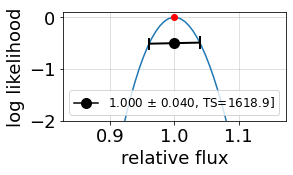

In [ ]:
# create a cell with 100 weights equal to 0.8
n = 1000
x = 0.8
w = np.full(n, x, np.float32)
cell = dict( n=n, w=w, S=n*x, B=n*(1-x) )

ll = LogLike(cell)
print(ll)
ll.plot()

fun = ll; grad=ll.gradient
def check(pars, xtol=1e-3):
    pars = np.atleast_1d(pars)
    print(f'pars: {pars.round(4)},  function: {fun(pars):.3f}, gradient: {(np.array(grad(pars))).round(4)}')
    pars = ll.solve(fix_beta=False, estimate=pars, xtol=xtol)
    print(f'pars: {pars.round(4)},  function: {fun(pars):.3f}, gradient: {(np.array(grad(pars))).round(4)}')
    
check([1.,0.])

check([1.5,0.1], xtol=1e-3)


In [ ]:
def test(self, pars):
    pars = np.atleast_1d(pars)
    if len(pars)>1:      alpha, beta = pars - np.array([1,0])
    else:                alpha, beta = max(-1, pars[0]-1), 0
    tmp =  1 + alpha*self.w + beta*(1-self.w)
    # limit alpha
    tmp[tmp<=1e-6]=1e-6

    return np.sum( np.log(tmp)) - alpha*self.S - beta*self.B
test(ll, 1), test(ll, [1,0.5])

(0.0, -4.689796447753878)

#### Poisson representation development

LogLike fit info:{'counts': 1000, 'flux': 1.0, 'sig_flux': 0.0395}
PoissonRep:   1.000[1+0.039-0.040], < 1.07, poiss: Poisson: mu,beta= 1000.0, 200.0
poisson pars: [1.0e+00 8.0e+02 2.5e-01]
poisson info:
{'flux': 1.0, 'ts': 1618.9, 'errors': (0.0399, -0.0391), 'limit': 1.067} 
Get poisson parmeters from n=1000, m=1.0, sig=0.04
Poisson: mu,beta= 1000.0, 209.4 [1.0, 790.5694150420948, 0.2649110640673519]


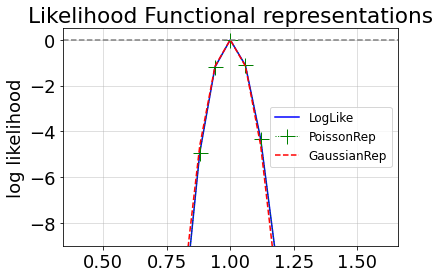

In [ ]:

info = ll.fit_info()
print(f'LogLike fit info:{info}')
pr = PoissonRep(ll, ts_min=15)
print(f'PoissonRep: {pr}, poiss: {pr.poiss}')
pars = np.array(pr.poiss.p).round(3)
print(f'poisson pars: {pars}')
print(f'poisson info:\n{pr.info()} ')

n, m, sig = np.array(list(info.values())).round(3)
print(f'Get poisson parmeters from n={int(n)}, m={m}, sig={sig}')
mu, beta = n, n-np.sqrt(n)/sig
e = m*(mu-beta)
b = beta/e
pois = Poisson([m, e , b])
print(pois, pois.p)
pr.comparison_plots(xlim=(0.4, 1.6), ylabel='log likelihood' ,
                    title='Likelihood Functional representations')

In [ ]:
#export
class PoissonRepTable(PoissonRep):
    """
    Create a table, then interpolate it
    """

    def __init__(self, loglike):
        # PoissonRep fits to Poisson
        super().__init__(loglike, )
        # now make a table and add to dict
        self.dom,self.cod = self.create_table()

    def __call__(self, x):
        return np.interp(x, np.linspace(*self.dom), self.cod)

In [ ]:
# prt = PoissonRepTable(ll)
# prt.dom

In [ ]:
#hide
from nbdev.export import notebook2script
notebook2script()
!date

Converted 00_config.ipynb.
Converted 01_data_man.ipynb.
Converted 02_effective_area.ipynb.
Converted 03_sources.ipynb.
Converted 04_load_data.ipynb.
Converted 04_simulation.ipynb.
Converted 05_source_data.ipynb.
Converted 06_poisson.ipynb.
Converted 07_loglike.ipynb.
Converted 08_cell_data.ipynb.
Converted 09_lightcurve.ipynb.
Converted 14_bayesian.ipynb.
Converted 90_main.ipynb.
Converted 99_tutorial.ipynb.
Converted index.ipynb.
Sun Jul  4 10:30:43 PDT 2021
